In [25]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%config InlineBackend.figure_format = 'retina'

In [3]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import logging
logging.basicConfig(level=logging.INFO)

In [4]:
epoch_key = ('HPa', 6, 2)

In [6]:
from src.parameters import (ANIMALS, SAMPLING_FREQUENCY)
from loren_frank_data_processing import get_interpolated_position_dataframe, make_neuron_dataframe

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)

neuron_info = make_neuron_dataframe(ANIMALS).xs(
    epoch_key, drop_level=False).query('numspikes > 0')

ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPa_direct/HPaDIO06.mat
ERROR:loren_frank_data_processing.core:Failed to load file: /Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/../Raw-Data/HPa_direct/HPaDIO06.mat


In [8]:
from src.spike_models import fit_1D_position

results = {}

results['1D_place_fields'] =  xr.concat(
    [fit_1D_position(
        neuron_key, ANIMALS, SAMPLING_FREQUENCY, position_info,
        penalty=1E-4)
     for neuron_key in neuron_info.index], dim=neuron_info.neuron_id)

INFO:src.spike_models:Fitting 1D position model for ('HPa', 6, 2, 1, 1)
INFO:src.spike_models:Fitting 1D position model for ('HPa', 6, 2, 1, 2)
INFO:src.spike_models:Fitting 1D position model for ('HPa', 6, 2, 1, 3)
INFO:src.spike_models:Fitting 1D position model for ('HPa', 6, 2, 1, 4)
INFO:src.spike_models:Fitting 1D position model for ('HPa', 6, 2, 1, 5)
INFO:src.spike_models:Fitting 1D position model for ('HPa', 6, 2, 1, 6)
INFO:src.spike_models:Fitting 1D position model for ('HPa', 6, 2, 4, 1)
INFO:src.spike_models:Fitting 1D position model for ('HPa', 6, 2, 4, 2)
INFO:src.spike_models:Fitting 1D position model for ('HPa', 6, 2, 4, 3)
INFO:src.spike_models:Fitting 1D position model for ('HPa', 6, 2, 4, 4)
INFO:src.spike_models:Fitting 1D position model for ('HPa', 6, 2, 4, 5)
INFO:src.spike_models:Fitting 1D position model for ('HPa', 6, 2, 4, 6)
INFO:src.spike_models:Fitting 1D position model for ('HPa', 6, 2, 5, 1)
INFO:src.spike_models:Fitting 1D position model for ('HPa', 6, 2

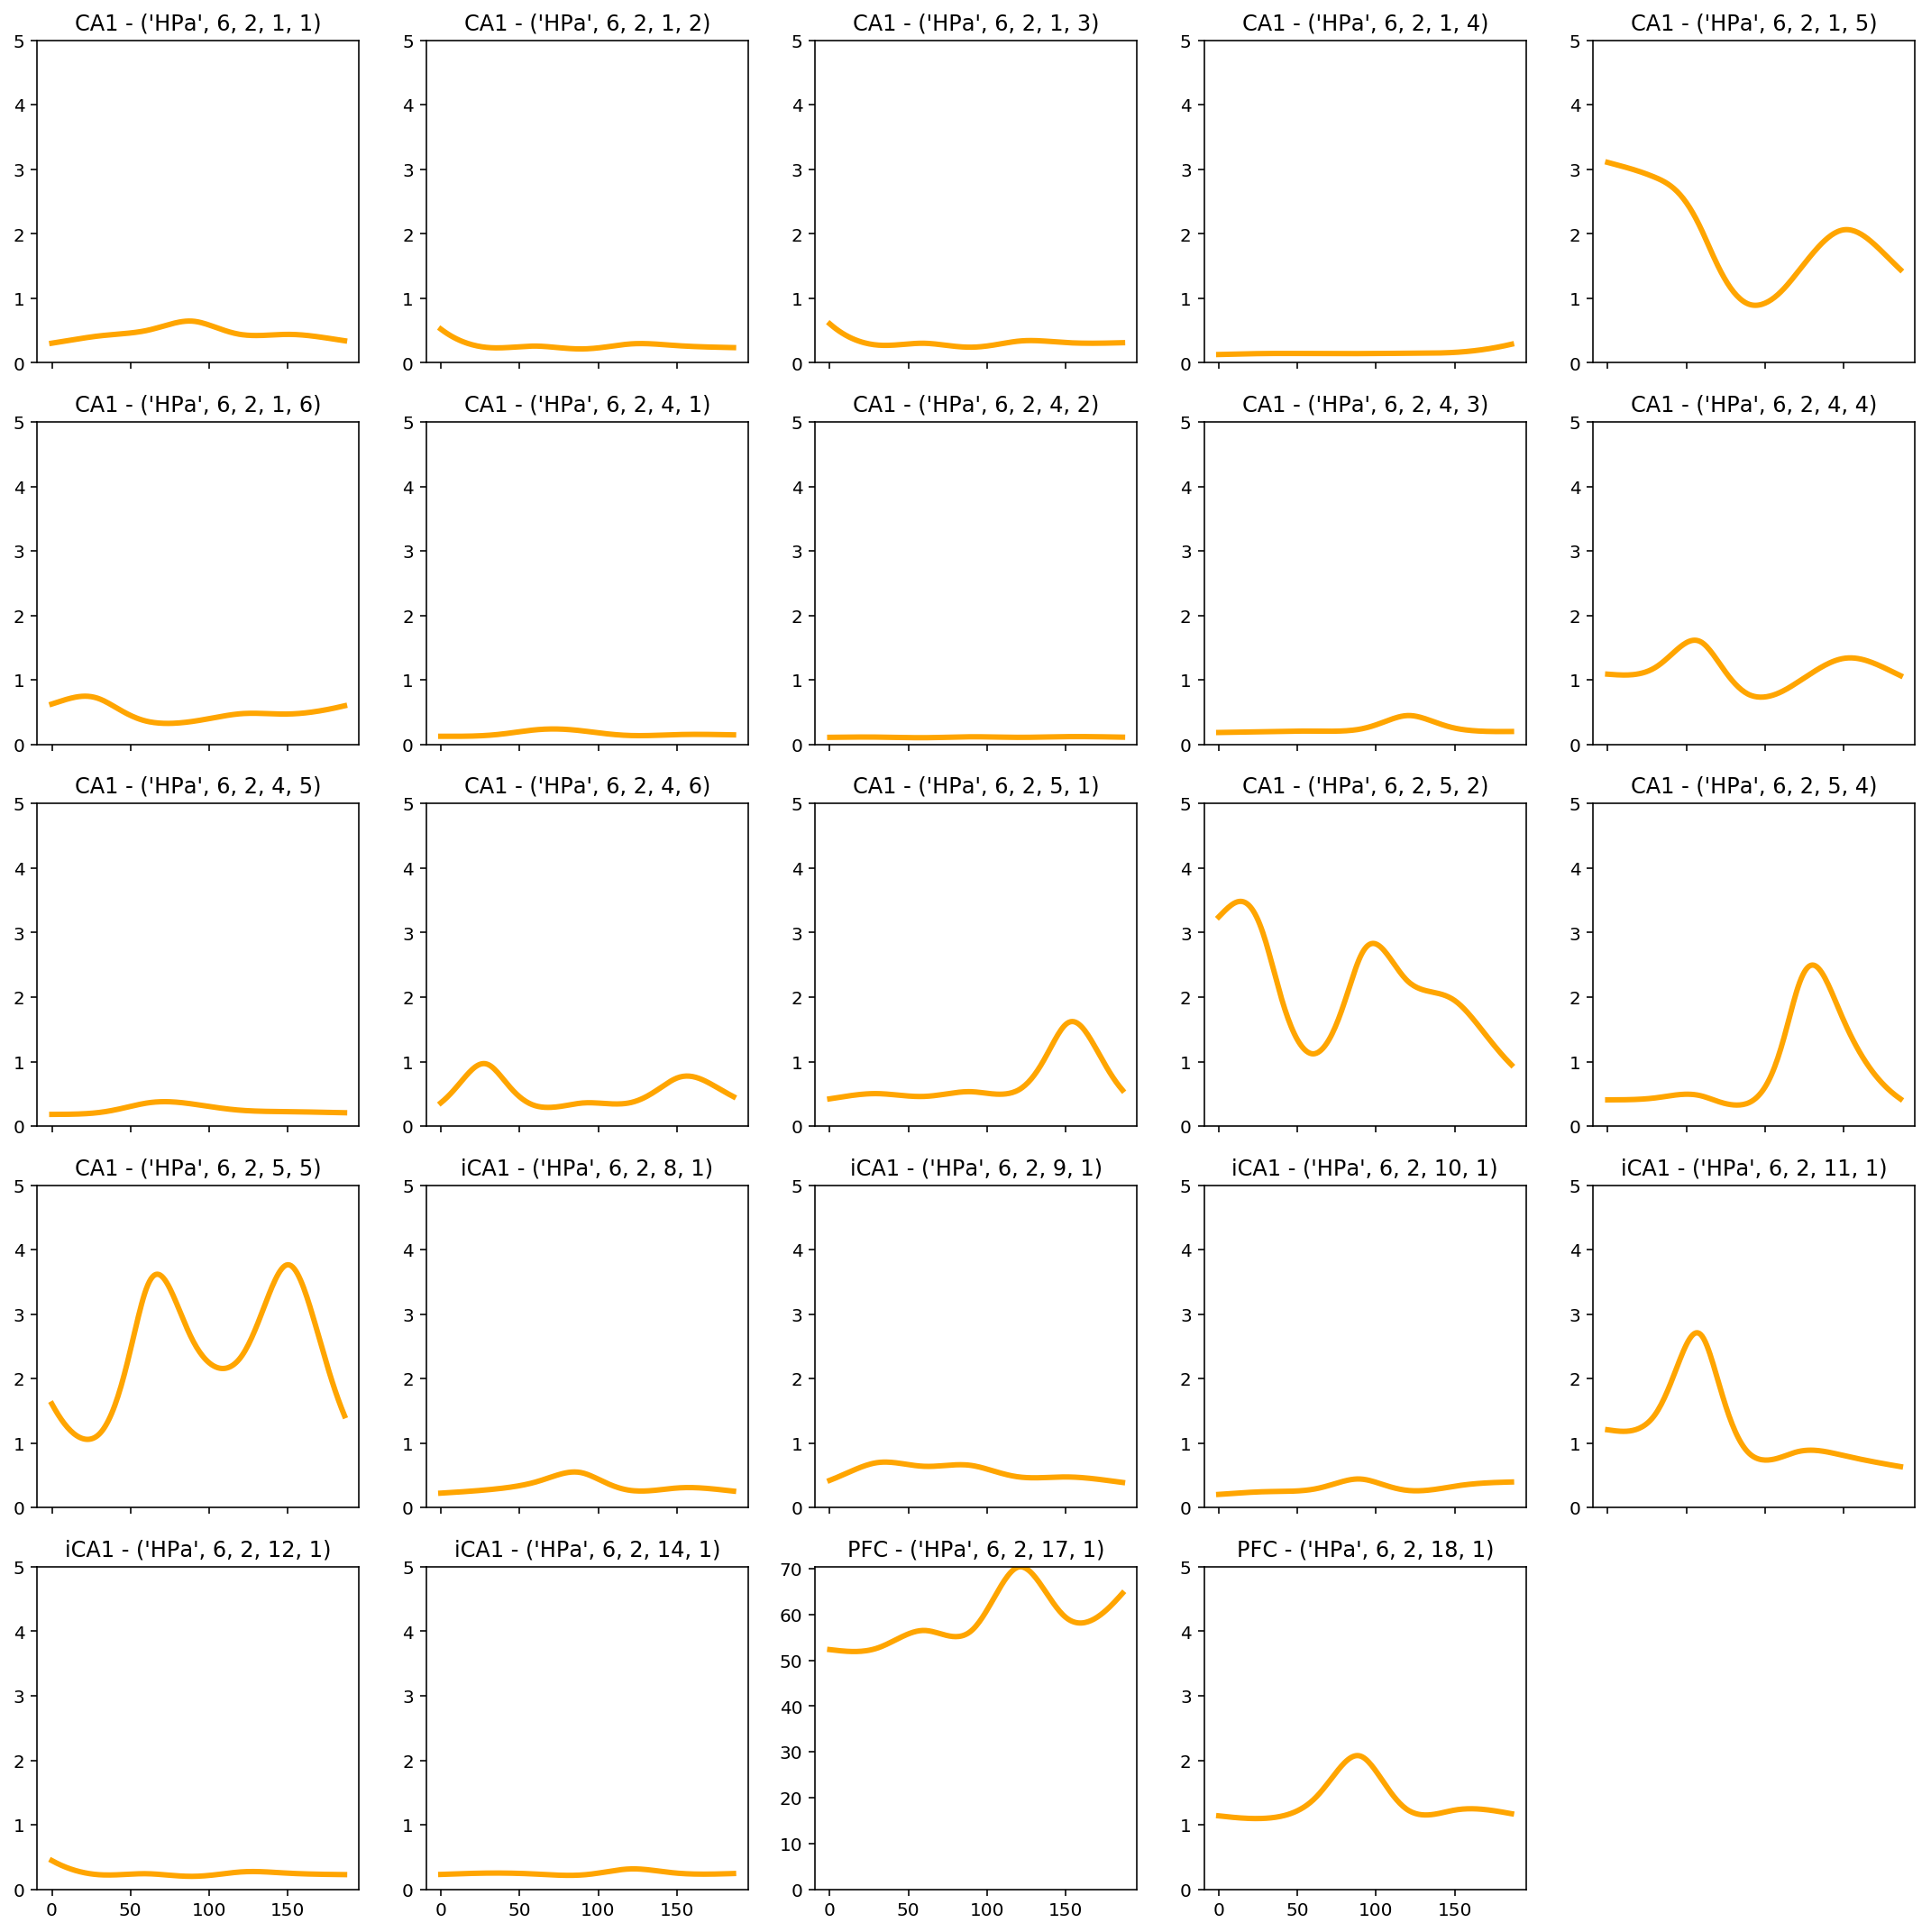

In [17]:
neuron_keys = neuron_info.index
n_neurons = len(neuron_keys)

col_wrap = 5
n_rows = np.ceil(n_neurons / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True)
for ax, neuron_key in zip(axes.ravel(), neuron_keys):
    predicted_rate = results['1D_place_fields'].sel(
        neuron_id=neuron_info.loc[neuron_key].neuron_id).firing_rate
    ax.plot(results['1D_place_fields'].position, predicted_rate, color='orange', linewidth=3)
    ax.set_ylim((0, np.max([5, predicted_rate.max().values])))
    ax.set_title('{area} - {key}'.format(
        area=neuron_info.loc[neuron_key].area,
        key=neuron_key,
    ))
    
for ax in axes.ravel()[n_neurons:]:
    ax.axis('off')

plt.tight_layout()

Steps
+ Filter LFP for theta (4-8 Hz)
+ Extract instantaneous phase
+ Plot instantaneous phase at spikes by position

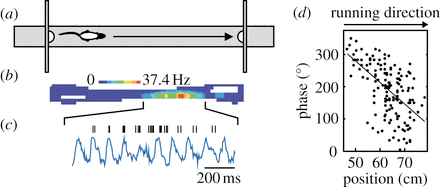

In [20]:
neuron_key = ('HPa', 6, 2, 5, 4)
tetrode_key = neuron_key[:4]

In [22]:
from loren_frank_data_processing import get_LFPs

lfp = get_LFPs([tetrode_key], ANIMALS)

lfp.head()

,electric_potential
time,
01:08:42.992000,43.0
01:08:42.992667,51.0
01:08:42.993333,53.0
01:08:42.994000,61.0
01:08:42.994667,70.0


In [42]:
from spectral_connectivity import Multitaper, Connectivity
from loren_frank_data_processing import make_tetrode_dataframe

tetrode_info = make_tetrode_dataframe(ANIMALS).xs(epoch_key, drop_level=False)

ca1_keys = tetrode_info.loc[tetrode_info.area.isin(['CA1', 'iCA1'])].index
ca1_lfps = lfdp.get_LFPs(ca1_keys, ANIMALS)
m = Multitaper(
    ca1_lfps.values, SAMPLING_FREQUENCY, time_window_duration=3.000,
    time_halfbandwidth_product=3, start_time=ca1_lfps.index.total_seconds()[0])
c = Connectivity.from_multitaper(m)
theta_power = xr.DataArray(
    c.power(), dims=('time', 'frequency', 'signals'),
    coords=dict(time=c.time + 0.500, frequency=c.frequencies, signals=ca1_keys), name='power')
m.frequency_resolution

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=3,
           time_window_duration=3.0, time_window_step=3.0,
           detrend_type='constant', start_time=4122.992, n_tapers=5)


1.0

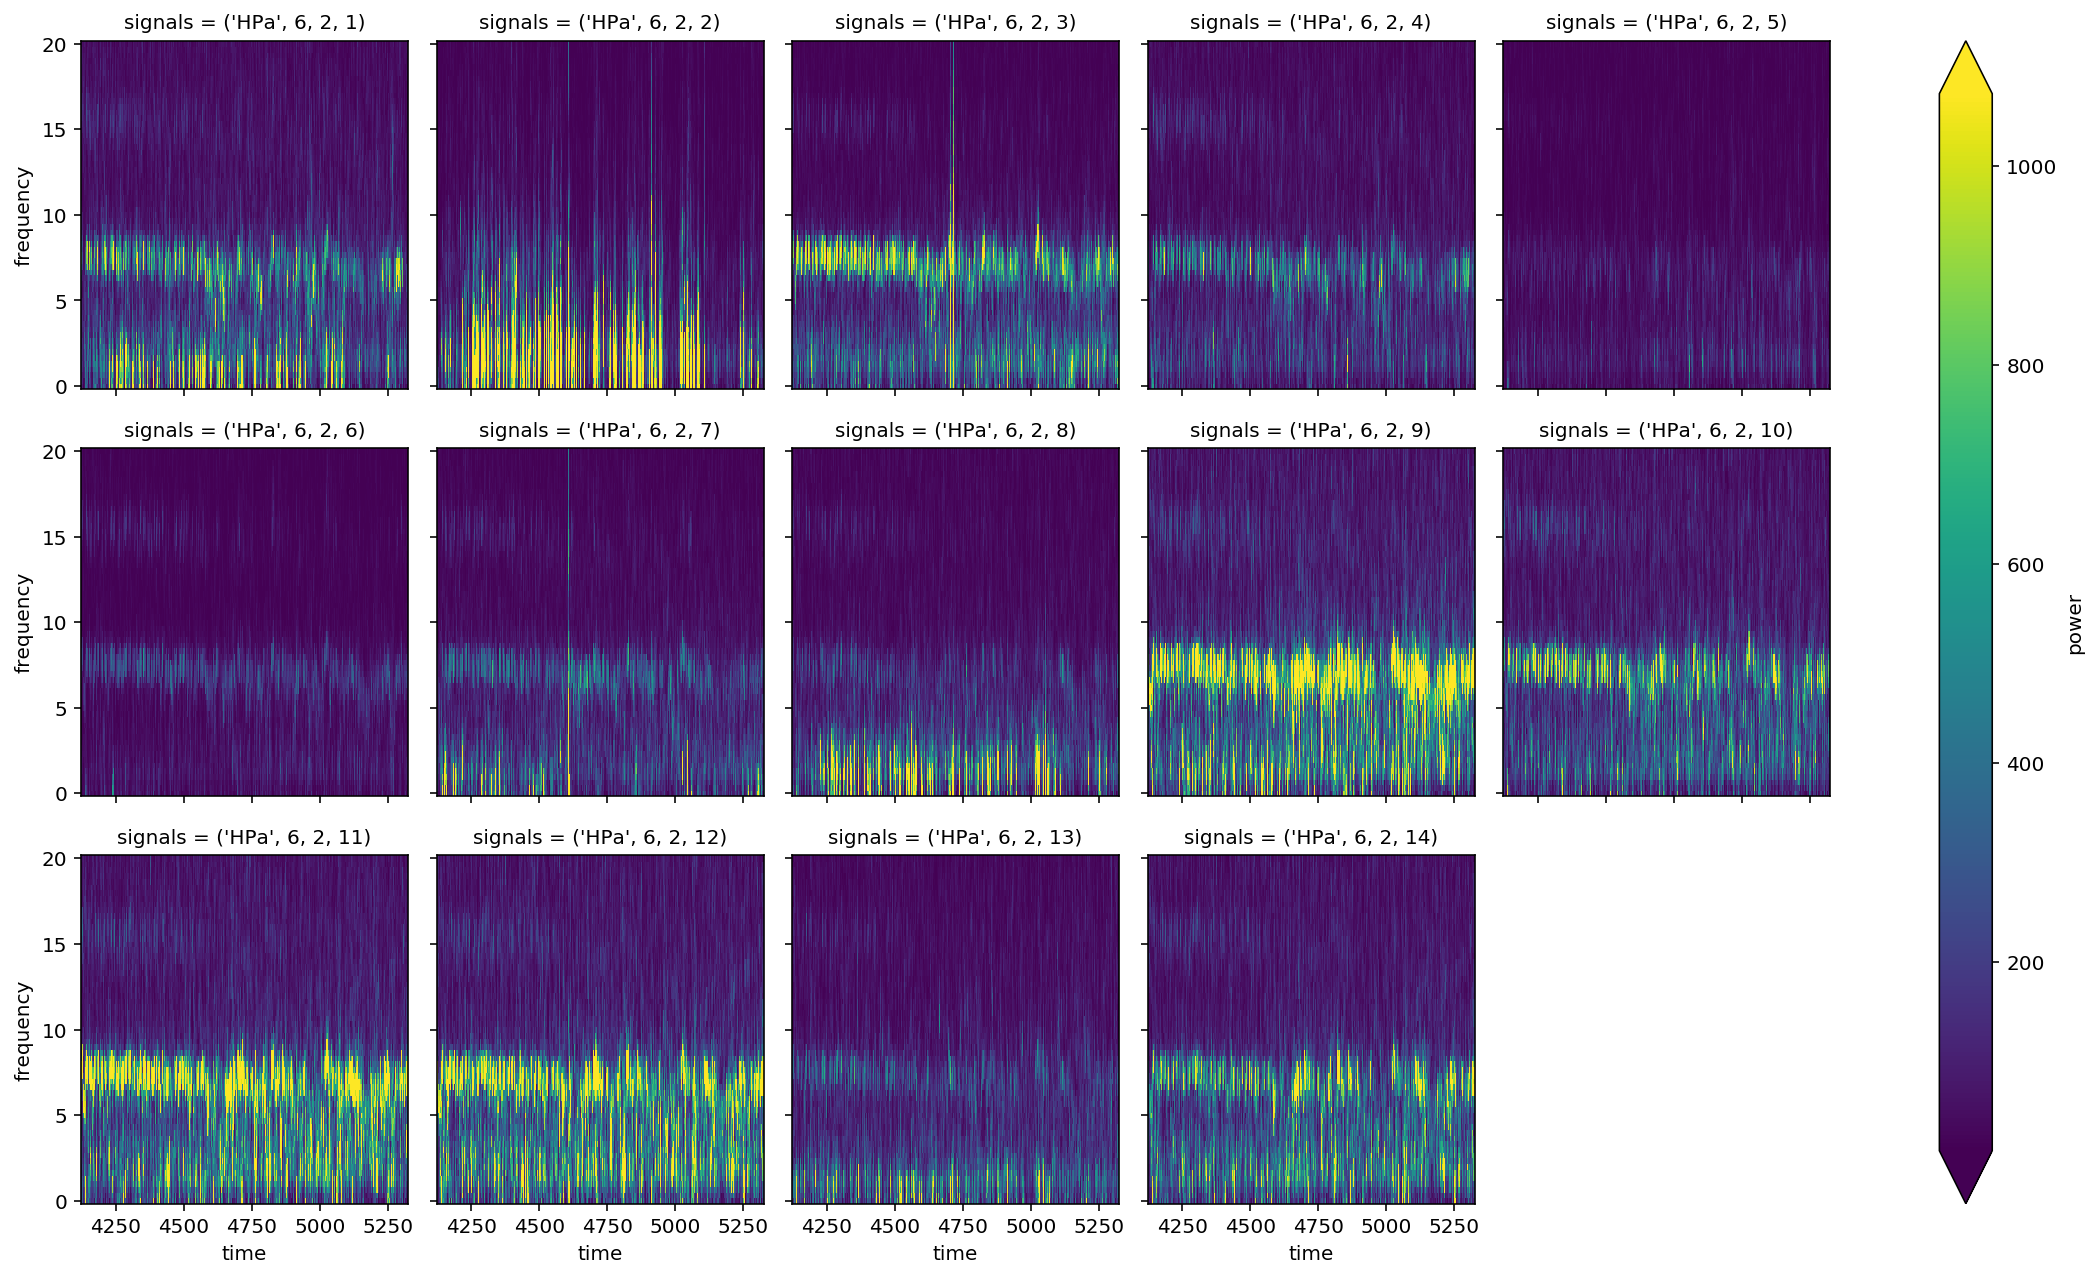

In [43]:
theta_power.sel(frequency=slice(0, 20)).plot(x='time', y='frequency', col='signals', col_wrap=5, robust=True);

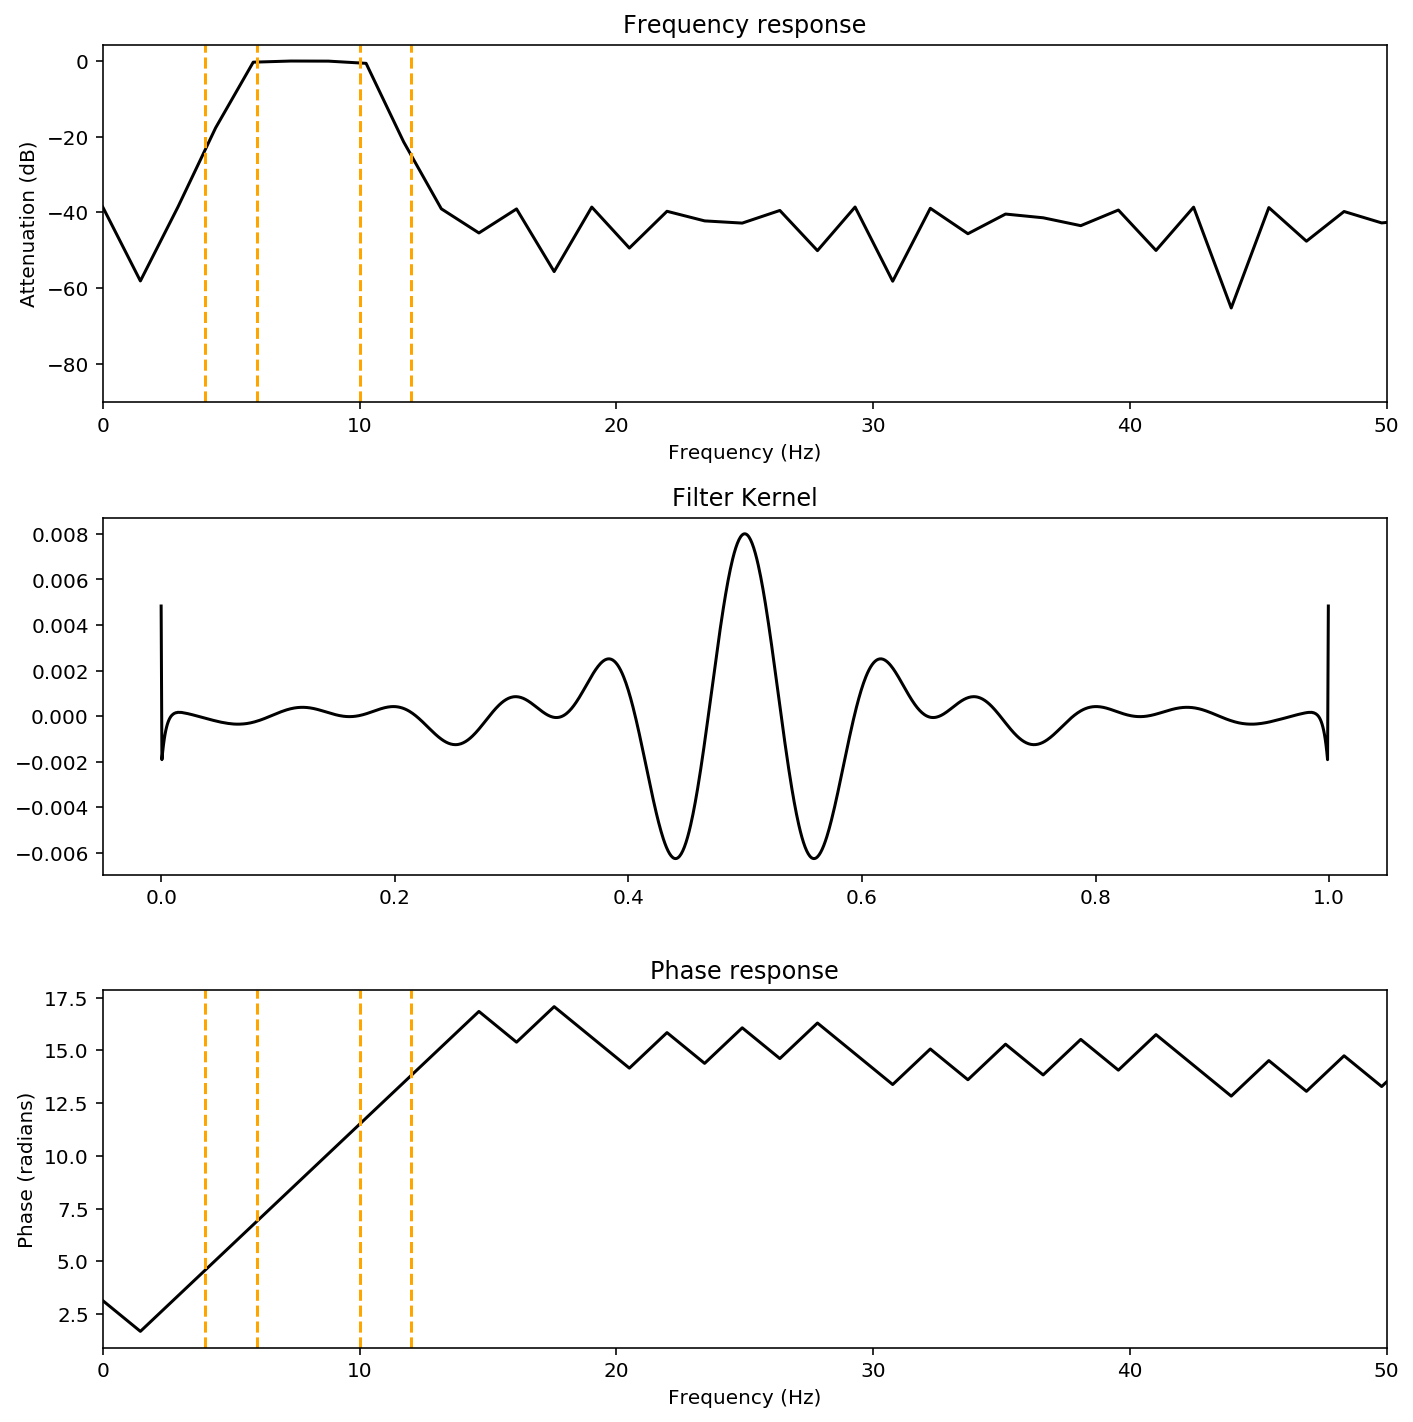

In [87]:
from scipy.signal import filtfilt, remez, hilbert, freqz

def theta_filter(sampling_frequency):
    ORDER = 1500
    nyquist = 0.5 * sampling_frequency
    TRANSITION_BAND = 2
    THETA_BAND = [6, 10]
    desired = [0, THETA_BAND[0] - TRANSITION_BAND, THETA_BAND[0],
               THETA_BAND[1], THETA_BAND[1] + TRANSITION_BAND, nyquist]
    return remez(ORDER, desired, [0, 1, 0], Hz=sampling_frequency), 1.0


filter_numerator, filter_denominator = theta_filter(SAMPLING_FREQUENCY)


normalized_frequency, h = freqz(filter_numerator, filter_denominator)
frequency = normalized_frequency * SAMPLING_FREQUENCY / (2. * np.pi)
fig, axes = plt.subplots(3, 1, figsize=(10, 10))


axes[0].plot(frequency,
         20 * np.log10(np.abs(h)), color='black')
axes[0].set_title('Frequency response')
axes[0].set_ylabel('Attenuation (dB)')
axes[0].set_xlabel('Frequency (Hz)');
axes[0].set_xlim((0, 50))
axes[0].axvline(4, color='orange', linestyle='--')
axes[0].axvline(6, color='orange', linestyle='--')
axes[0].axvline(10, color='orange', linestyle='--')
axes[0].axvline(12, color='orange', linestyle='--')

axes[1].plot(np.arange(filter_numerator.size) / SAMPLING_FREQUENCY, filter_numerator, color='black')
axes[1].set_title('Filter Kernel');

h_phase = np.unwrap(np.arctan2(h.imag, h.real))
axes[2].plot(frequency, h_phase, color='black')
axes[2].set_ylabel('Phase (radians)')
axes[2].set_xlabel('Frequency (Hz)')
axes[2].set_title('Phase response')
axes[2].set_xlim((0, 50))
axes[2].axvline(4, color='orange', linestyle='--')
axes[2].axvline(6, color='orange', linestyle='--')
axes[2].axvline(10, color='orange', linestyle='--')
axes[2].axvline(12, color='orange', linestyle='--')

plt.tight_layout()

In [88]:
theta_filtered = filtfilt(
        filter_numerator, filter_denominator, lfp.values, axis=0)

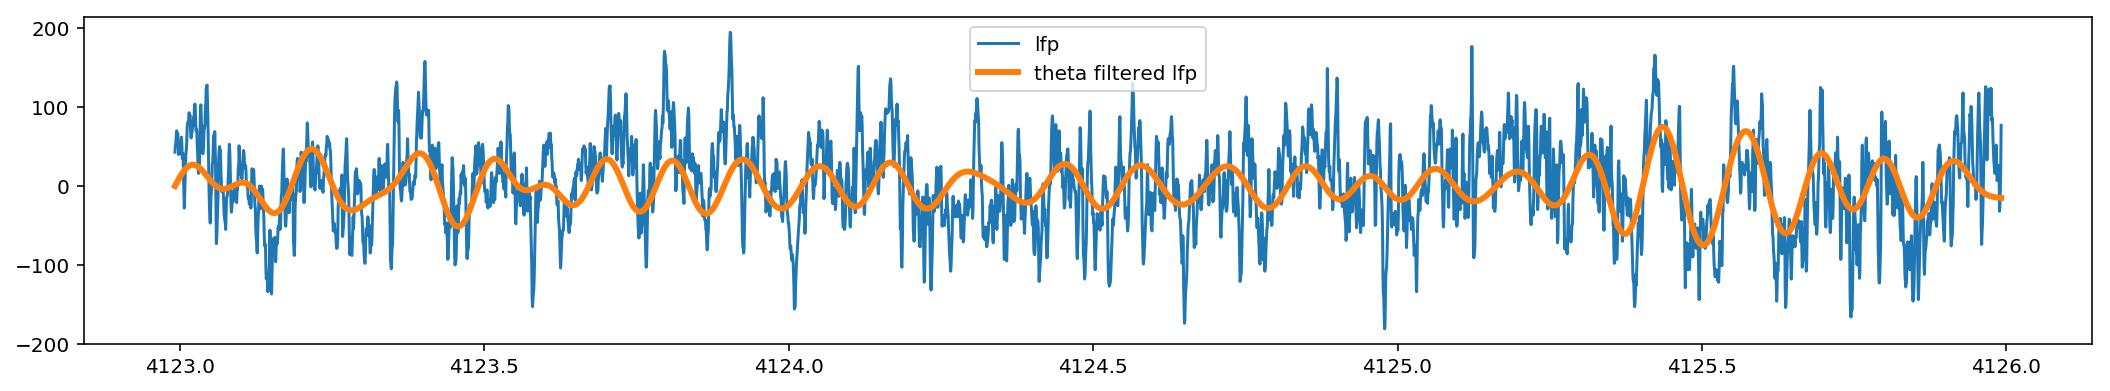

In [89]:
time = lfp.index.total_seconds().values

plt.figure(figsize=(18, 3))
plt.plot(time[:4500], lfp.values[:4500], label='lfp')
plt.plot(time[:4500], theta_filtered[:4500], label='theta filtered lfp', linewidth=3)
plt.legend();

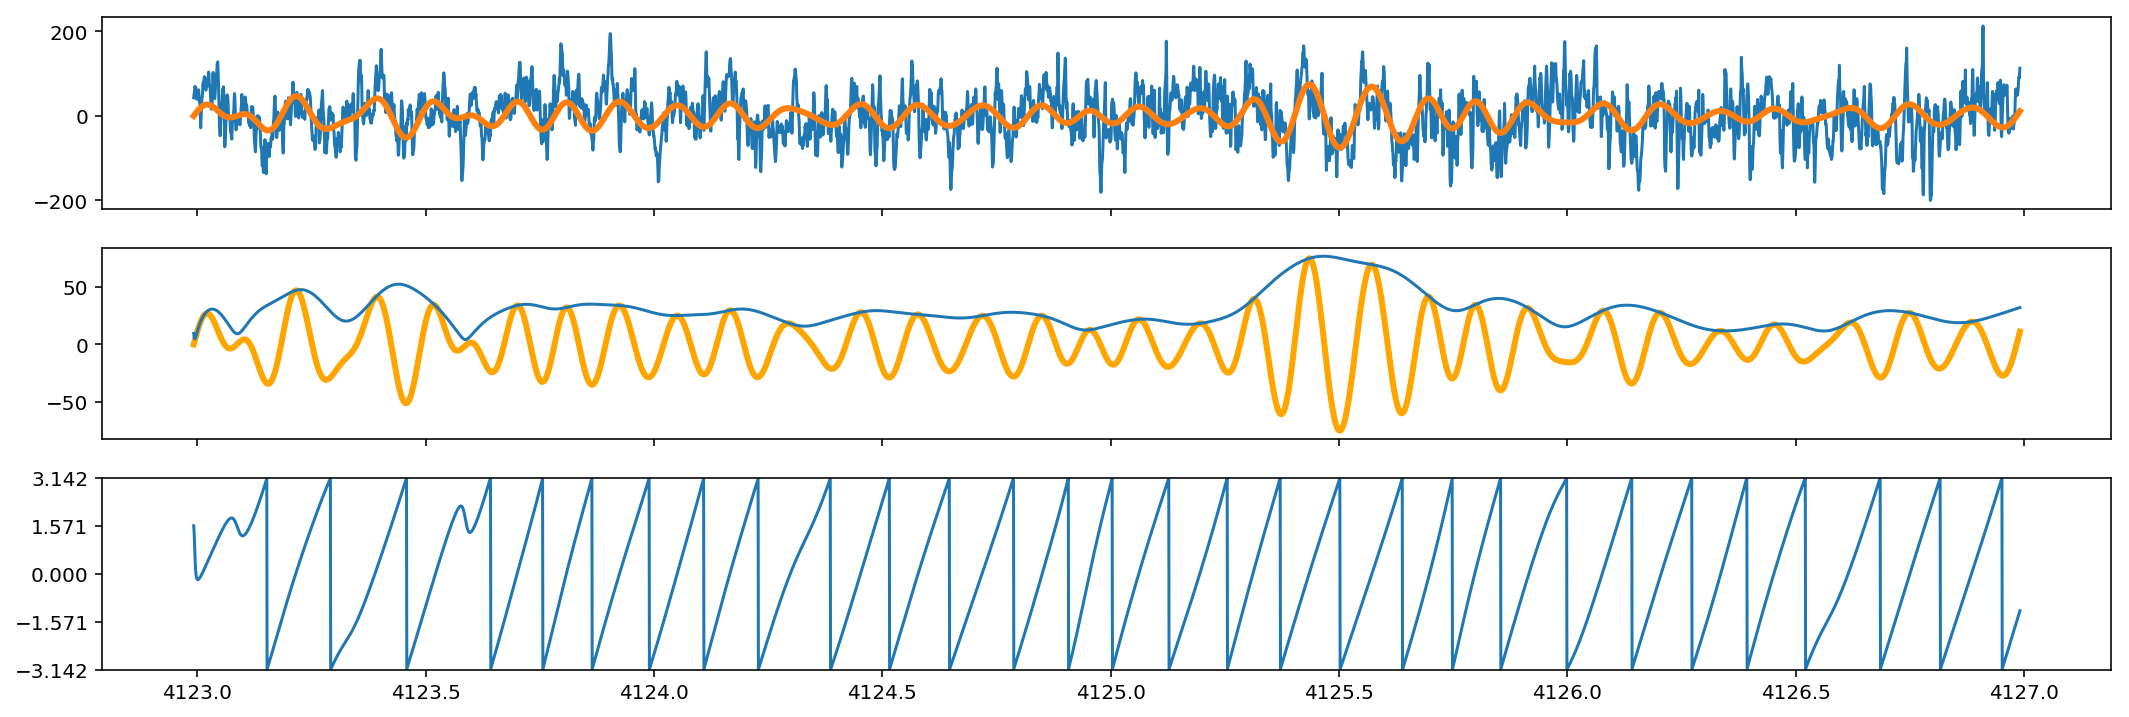

In [122]:
analytic_signal = hilbert(theta_filtered.squeeze())
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.angle(analytic_signal)

fig, axes = plt.subplots(3, 1, figsize=(18, 6), sharex=True)


index = slice(0, 6000)
axes[0].plot(time[index], lfp.values[index], label='lfp')
axes[0].plot(time[index], theta_filtered[index], label='theta filtered lfp', linewidth=3)
axes[1].plot(time[index], theta_filtered[index], label='theta filtered lfp', linewidth=3, color='orange')
axes[1].plot(time[index], amplitude_envelope[index])
axes[2].plot(time[index], instantaneous_phase[index]);
axes[2].set_ylim((-np.pi, np.pi));
axes[2].set_yticks([-np.pi, -0.5*np.pi, 0., 0.5*np.pi, np.pi]);

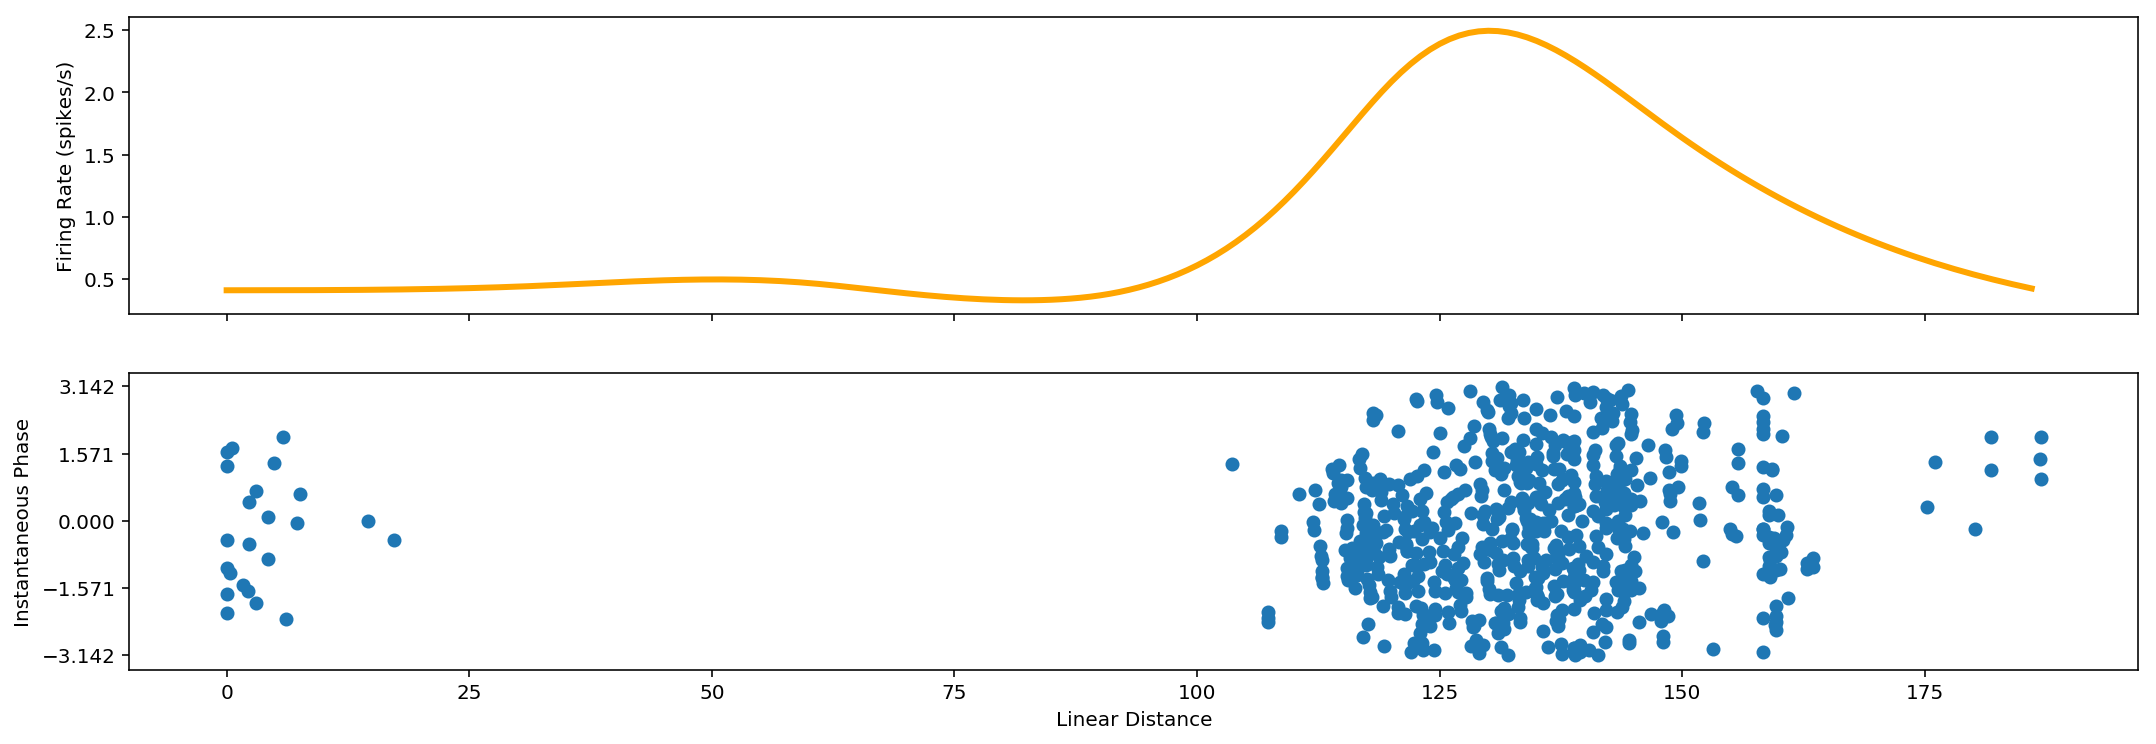

In [151]:
from loren_frank_data_processing import get_spike_indicator_dataframe

spikes = get_spike_indicator_dataframe(neuron_key, ANIMALS)
predicted_rate = results['1D_place_fields'].sel(
    neuron_id=neuron_info.loc[neuron_key].neuron_id).firing_rate

index = (spikes == 1)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(18, 6))

axes[0].plot(results['1D_place_fields'].position, predicted_rate, color='orange', linewidth=3)
axes[0].set_ylabel('Firing Rate (spikes/s)')
axes[1].scatter(
    position_info.loc[index].linear_distance.values,
    instantaneous_phase[index]);
axes[1].set_xlabel('Linear Distance')
axes[1].set_ylabel('Instantaneous Phase');
axes[1].set_yticks([-np.pi, -0.5*np.pi, 0., 0.5*np.pi, np.pi]);

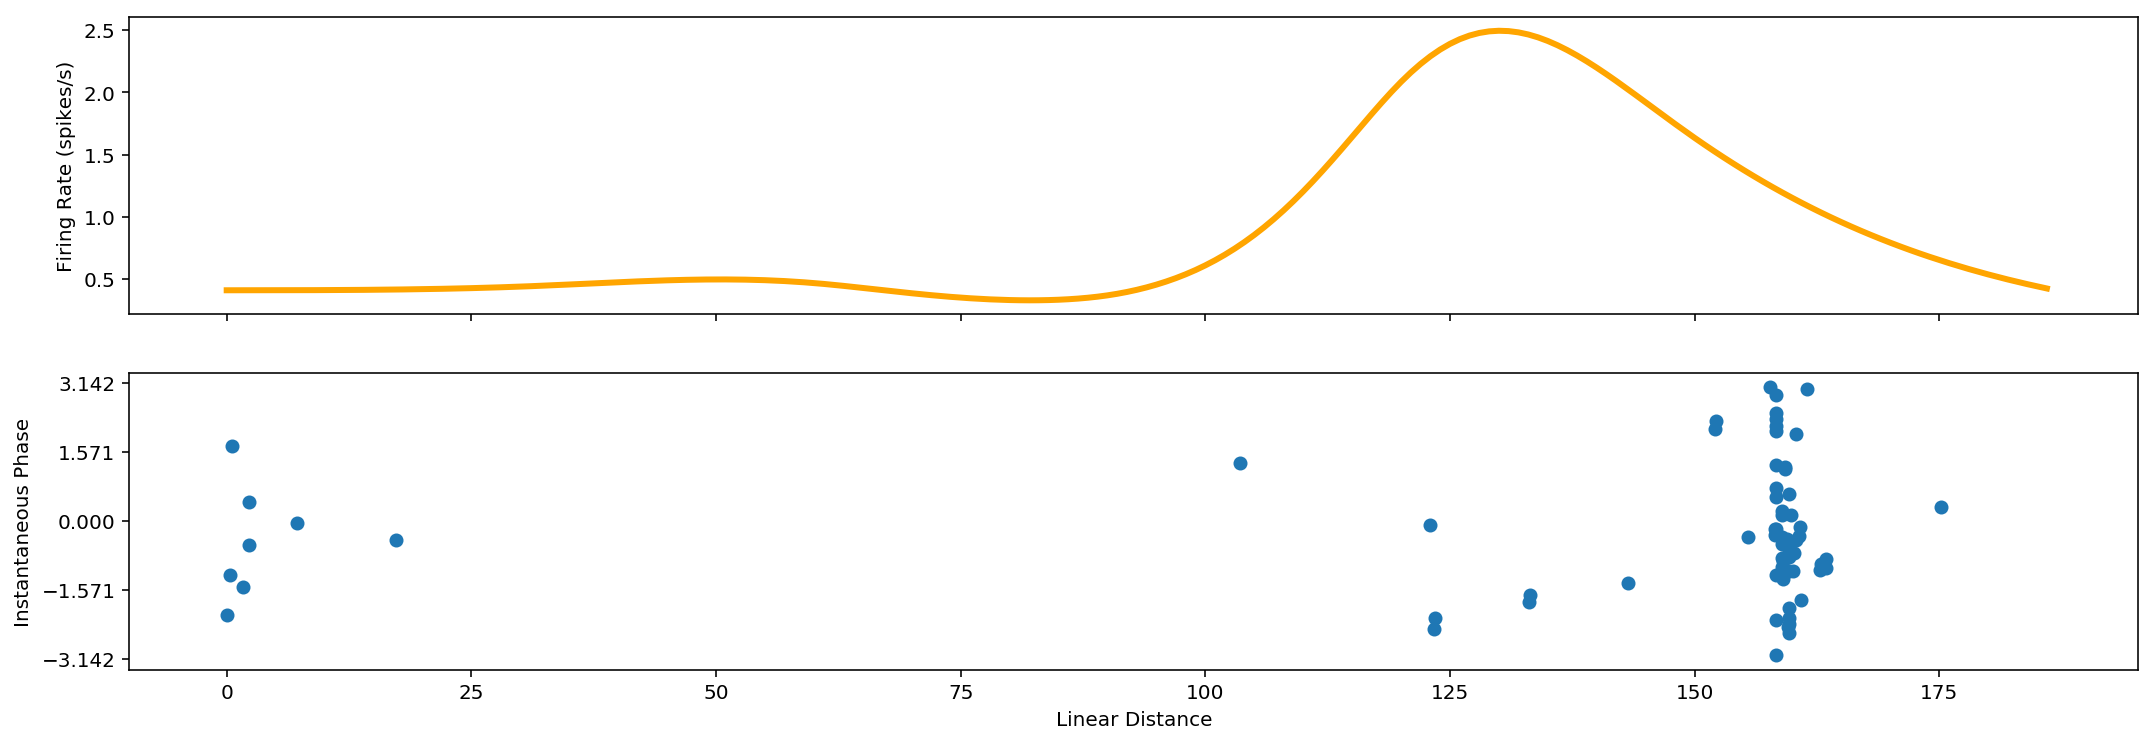

In [150]:
from loren_frank_data_processing import get_spike_indicator_dataframe

spikes = get_spike_indicator_dataframe(neuron_key, ANIMALS)
predicted_rate = results['1D_place_fields'].sel(
    neuron_id=neuron_info.loc[neuron_key].neuron_id).firing_rate

index = (spikes == 1) & (position_info.to_well == 'left')

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(18, 6))

axes[0].plot(results['1D_place_fields'].position, predicted_rate, color='orange', linewidth=3)
axes[0].set_ylabel('Firing Rate (spikes/s)')
axes[1].scatter(
    position_info.loc[index].linear_distance.values,
    instantaneous_phase[index]);
axes[1].set_xlabel('Linear Distance')
axes[1].set_ylabel('Instantaneous Phase');
axes[1].set_yticks([-np.pi, -0.5*np.pi, 0., 0.5*np.pi, np.pi]);

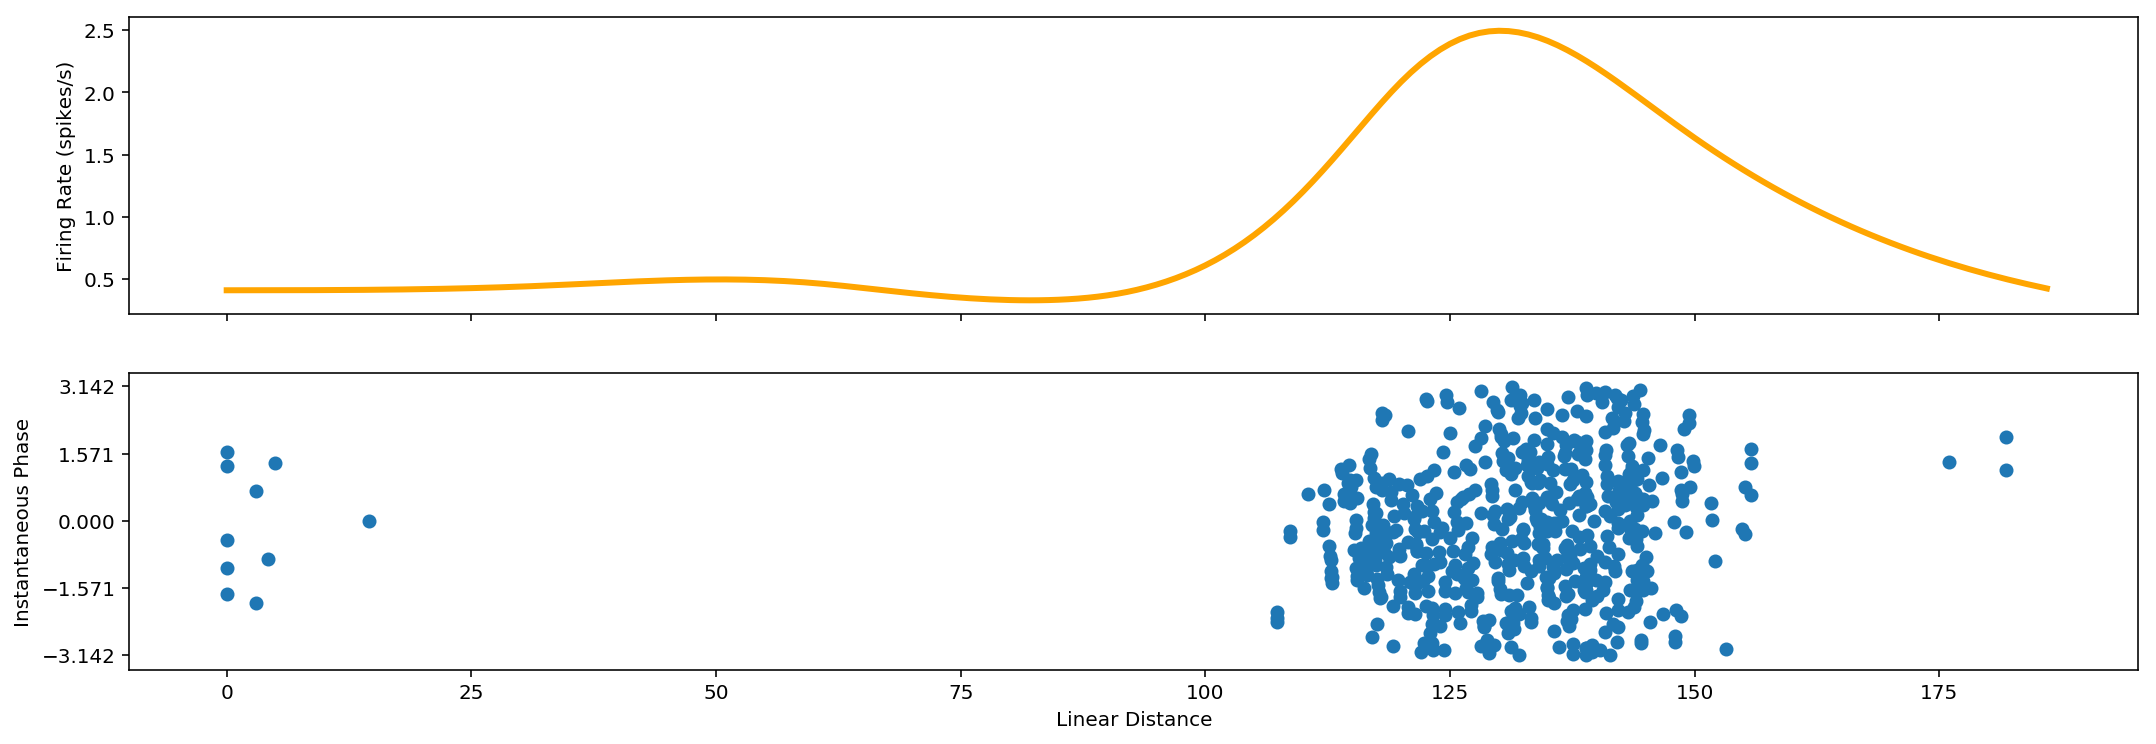

In [149]:
from loren_frank_data_processing import get_spike_indicator_dataframe

spikes = get_spike_indicator_dataframe(neuron_key, ANIMALS)
predicted_rate = results['1D_place_fields'].sel(
    neuron_id=neuron_info.loc[neuron_key].neuron_id).firing_rate

index = (spikes == 1) & (position_info.to_well == 'center')

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(18, 6))

axes[0].plot(results['1D_place_fields'].position, predicted_rate, color='orange', linewidth=3)
axes[0].set_ylabel('Firing Rate (spikes/s)')
axes[1].scatter(
    position_info.loc[index].linear_distance.values,
    instantaneous_phase[index]);
axes[1].set_xlabel('Linear Distance')
axes[1].set_ylabel('Instantaneous Phase');
axes[1].set_yticks([-np.pi, -0.5*np.pi, 0., 0.5*np.pi, np.pi]);